In [230]:
import math
import numpy as np
import pandas as pd
from scipy.spatial import Voronoi
from scipy.spatial import Delaunay
import networkx as nx
import random
import copy
from collections import defaultdict, Counter
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio.v2 as imageio
import os

from types import MappingProxyType

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [231]:
folder = '0827/packingFraction/'
nObstacles = 3000
seedNumber = 42
nProbes = 300

In [232]:
tetraInfo = pd.read_csv(folder + str(nObstacles) + '_' + str(seedNumber) + '_tetra.txt', sep=',')

In [233]:
pf = pd.read_csv(folder + 'pf_' + str(nObstacles) + '_' + str(nProbes) + '_' + str(seedNumber) + '.txt', sep=' ')
pf = pf.dropna(axis = 1)
numConfigurations = len(pf)

In [234]:
pfMax = pf.max()
pfMax.index = pfMax.index.astype(int)
pfMax = pfMax.sort_index()
pfMax = pd.DataFrame({'max pf': pfMax})
pfMax = pfMax.reset_index()
pfMax = pfMax.rename(columns={'index': 'id'})

tetraInfo = tetraInfo.merge(pfMax, on='id', how = 'left')
tetraInfo[(~tetraInfo['is_percolation']) & (tetraInfo['max pf'] > 0)].sort_values('max pf')

,id,obstacles_id,x,y,z,is_prime,image_id,is_percolation,percolation_id,volume,vol_fraction,vol_fraction_cum,num_probes,max pf


In [235]:
pf = pf.T
pf.index = pf.index.astype(int)
pf = pf.reset_index()
pf = pf.rename(columns={'index': 'id'})
pf = pf.sort_index()

In [236]:
percolation = pf.copy()
percolation = percolation.set_index('id')
tetraInfo = tetraInfo.set_index('id')

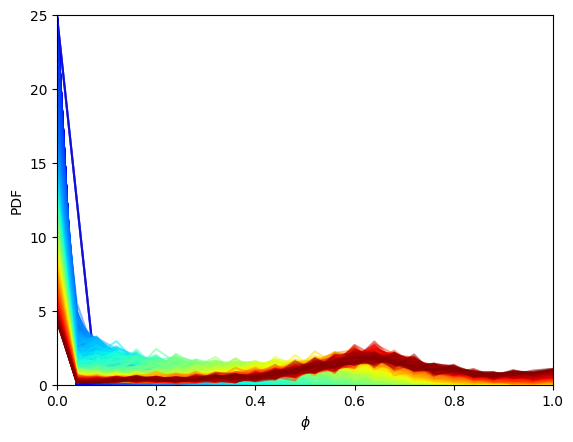

In [237]:
import matplotlib.cm as cm
cmap = cm.get_cmap("jet", numConfigurations)

yArray = []
xArray = []
for i in range(0, numConfigurations):
    binNumber = (percolation[i] * 100 // 4).astype(int)
    weights = tetraInfo.loc[percolation.index, 'vol_fraction']
    weights = weights / weights.sum()

    data = pd.DataFrame({'binNumber': binNumber, 'weight': weights})
    pdf = data.groupby('binNumber')['weight'].sum()
    pdf = pdf.sort_index()

    x = (pdf.index * 4) / 100
    y = pdf.values
    xArray.append(np.array(x))
    yArray.append(np.array(y))
    plt.plot(x,y * 25, alpha=0.5, color=cmap(i))

plt.ylim(0,25)
plt.xlim(0,1)
plt.xlabel(r"$\phi$")
plt.ylabel(r"PDF")
plt.show()

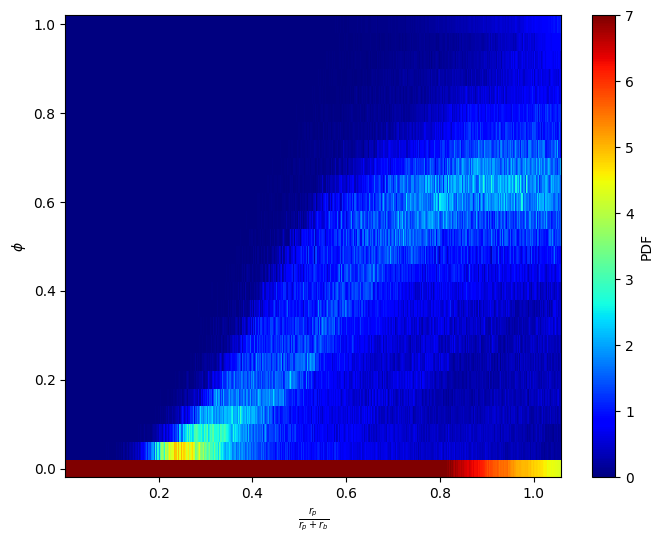

In [238]:
X = np.arange(numConfigurations)
Y = xArray[-1]  # assuming Y is 1D array of length len(Y)

Z = []
for i in range(len(Y)):
    row = []
    for j in range(numConfigurations):
        pf = i * 0.04
        if pf not in xArray[j]:
            row.append(0.0)
        else:
            ind = np.where(xArray[j] == pf)[0][0]
            row.append(float(yArray[j][ind]))
    Z.append(row)

Z = np.array(Z)  # shape (len(Y), numConfigurations)
Z = Z*25
Z[np.where(Z > 7)] = 7
# Build meshgrid
Xg, Yg = np.meshgrid(X, Y)

plt.figure(figsize=(8,6))
pc = plt.pcolormesh((Xg+1)/500, Yg, Z, cmap="jet", shading="auto")
plt.colorbar(pc, label="PDF")

plt.xlabel(r"$\frac{r_p}{r_p+r_b}$")
plt.ylabel(r"$\phi$")
plt.show()

In [239]:
cols = [i for i in range(numConfigurations)]
weighted = percolation.copy()
weighted[cols] *= tetraInfo.loc[weighted.index, "vol_fraction"].to_numpy()[:, None]

0.52660854890421


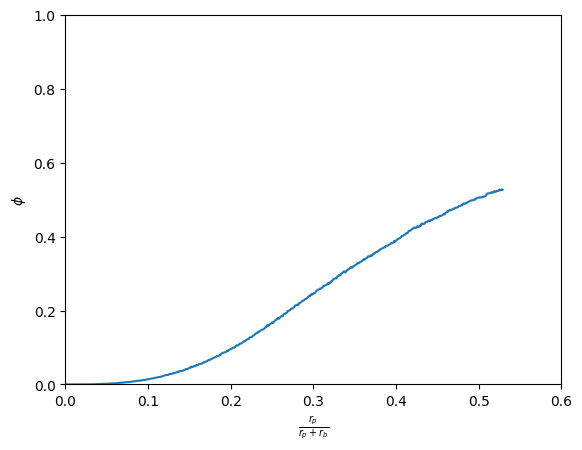

In [240]:
y = weighted.sum()
x = weighted.sum().index
plt.plot((x+1) / 1000, y)
plt.ylim(0,1)
plt.xlim(0,0.6)
plt.xlabel(r"$\frac{r_p}{r_p+r_b}$")
plt.ylabel(r"$\phi$")

print(y.iloc[-1])

0.6309777478587895


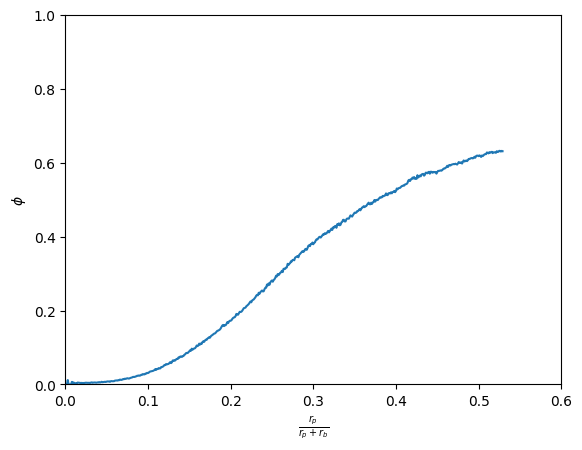

In [241]:
pf = []
for i in range(numConfigurations):
    pfi = 0
    sumVol = 0
    for ind, row in percolation.iterrows():
        vol = tetraInfo.loc[ind, 'vol_fraction']
        pfTmp = row[i]
        if pfTmp > 1e-8:
            sumVol += vol
            pfi += pfTmp * vol
    
    pf.append(pfi / sumVol if sumVol > 1e-8 else 0)

plt.plot((x+1) / 1000, pf)
plt.ylim(0,1)
plt.xlim(0,0.6)
plt.xlabel(r"$\frac{r_p}{r_p+r_b}$")
plt.ylabel(r"$\phi$")

print(pf[-1])